In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/food_rescue_preferences')

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
from rmab.utils import get_results_matching_parameters
from rmab.plots import aggregate_data, aggregate_normalize_data
import seaborn as sns
from rmab.fr_dynamics import get_all_transitions
import random 
import math
from copy import deepcopy
import scipy.stats as stats 

In [4]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')


In [5]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [6]:
colors_by_method = {}
baseline_methods = ['random','shapley_whittle','whittle_activity']
our_methods = ['individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','linear_program']

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(our_methods)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(our_methods):
    colors_by_method[m] = vidris[i]
colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])

## Unknown Transitions Plots

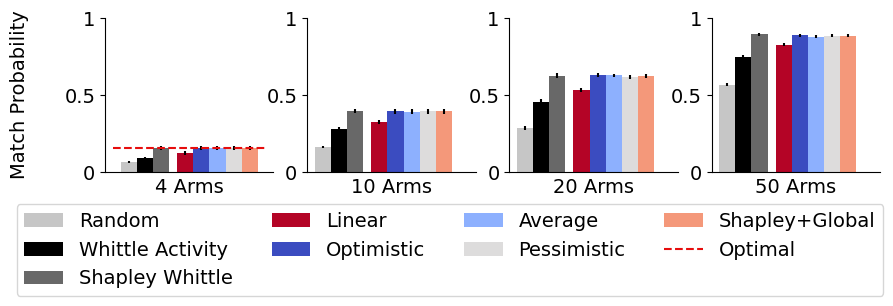

In [7]:
fig, axs = plt.subplots(1,4, figsize=(10, 2))
method_names = ['random','whittle_activity','shapley_whittle','linear_program','individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','optimal']
nice_names = ["Random","Whittle Activity","Shapley Whittle","Linear","Optimistic","Average","Pessimistic","Shapley+Global","Optimal"]
width = 0.1
n_arms = [4,10,20,50]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0, 'prob_distro': 'global_transition','reward_type': 'global_transition'}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_program':
        shift += 0.5 

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    baseline_params['n_arms'] = n
    baseline_params['budget'] = n//2 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "unknown_transitions/baseline_policies"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results)
            if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0,1])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("{} Arms".format(n_arms[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Probability",fontsize=14,x=0.03)
fig.savefig("../../results/figures/transition_n_arms.pdf",dpi=300, bbox_inches='tight')


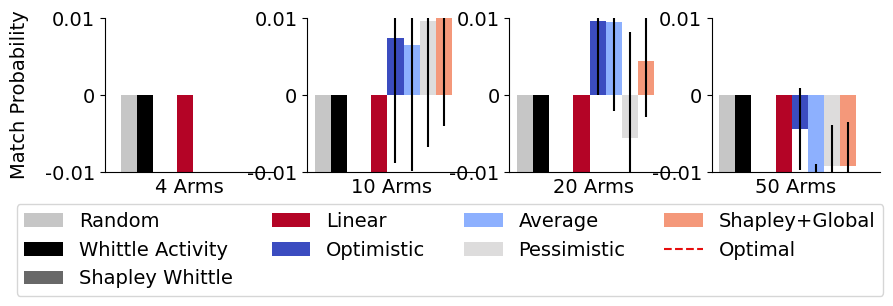

In [8]:
fig, axs = plt.subplots(1,4, figsize=(10, 2))
method_names = ['random','whittle_activity','shapley_whittle','linear_program','individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','optimal']
nice_names = ["Random","Whittle Activity","Shapley Whittle","Linear","Optimistic","Average","Pessimistic","Shapley+Global","Optimal"]
width = 0.1
n_arms = [4,10,20,50]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0, 'prob_distro': 'global_transition','reward_type': 'global_transition'}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_program':
        shift += 0.5 

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    baseline_params['n_arms'] = n
    baseline_params['budget'] = n//2 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "unknown_transitions/baseline_policies"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="shapley_whittle")
            if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([-0.01,0,0.01],[-0.01,0,0.01],fontsize=14)
    axs[i].set_ylim([-0.01,0.01])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("{} Arms".format(n_arms[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Probability",fontsize=14,x=0.03)
fig.savefig("../../results/figures/transition_n_arms.pdf",dpi=300, bbox_inches='tight')


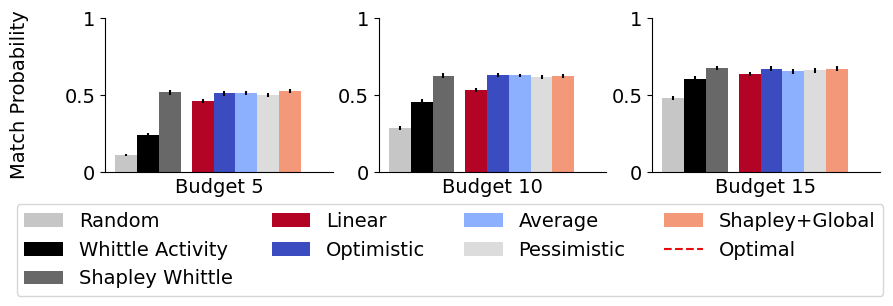

In [9]:
fig, axs = plt.subplots(1,3, figsize=(10, 2))
method_names = ['random','whittle_activity','shapley_whittle','linear_program','individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','optimal']
nice_names = ["Random","Whittle Activity","Shapley Whittle","Linear","Optimistic","Average","Pessimistic","Shapley+Global","Optimal"]
width = 0.1
budgets = [5,10,15]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0, 'prob_distro': 'global_transition','reward_type': 'global_transition','n_arms': 20}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_program':
        shift += 0.5 

    x_locations.append((i+shift)*width)

for i,b in enumerate(budgets):
    baseline_params['n_arms'] = baseline_params['n_arms']
    baseline_params['budget'] = b 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "unknown_transitions/baseline_policies"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_reward'][0])

        if num_data>0:
            results = aggregate_data(results)
            if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0,1])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("Budget {}".format(budgets[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Probability",fontsize=14,x=0.03)
fig.savefig("../../results/figures/transition_n_arms.pdf",dpi=300, bbox_inches='tight')


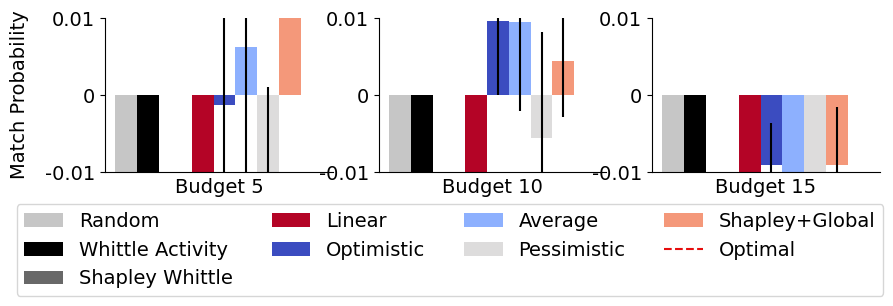

In [10]:
fig, axs = plt.subplots(1,3, figsize=(10, 2))
method_names = ['random','whittle_activity','shapley_whittle','linear_program','individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','optimal']
nice_names = ["Random","Whittle Activity","Shapley Whittle","Linear","Optimistic","Average","Pessimistic","Shapley+Global","Optimal"]
width = 0.1
budgets = [5,10,15]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0, 'prob_distro': 'global_transition','reward_type': 'global_transition','n_arms': 20}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_program':
        shift += 0.5 

    x_locations.append((i+shift)*width)

for i,b in enumerate(budgets):
    baseline_params['n_arms'] = baseline_params['n_arms']
    baseline_params['budget'] = b 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "unknown_transitions/baseline_policies"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline='shapley_whittle')
            if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([-0.01,0,0.01],[-0.01,0,0.01],fontsize=14)
    axs[i].set_ylim([-0.01,0.01])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("Budget {}".format(budgets[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Probability",fontsize=14,x=0.03)
fig.savefig("../../results/figures/transition_n_arms.pdf",dpi=300, bbox_inches='tight')


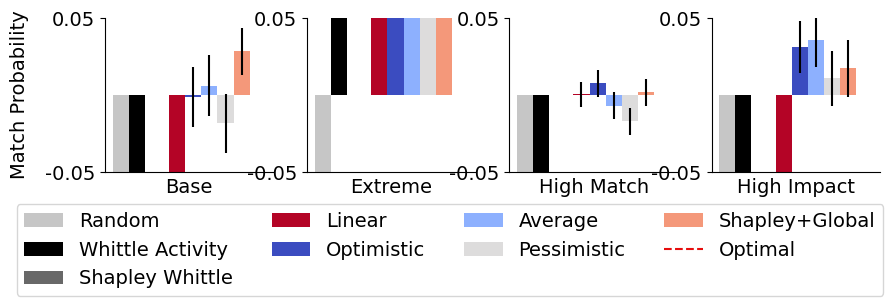

In [11]:
fig, axs = plt.subplots(1,4, figsize=(10, 2))
method_names = ['random','whittle_activity','shapley_whittle','linear_program','individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','optimal']
nice_names = ["Random","Whittle Activity","Shapley Whittle","Linear","Optimistic","Average","Pessimistic","Shapley+Global","Optimal"]
width = 0.1
n_arms = ['global_transition','global_transition_extreme' ,'global_transition_high_match','global_transition_high_match_impact']
prob_distros = ["Base","Extreme","High Match","High Impact"]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0, 'prob_distro': 'global_transition','reward_type': 'global_transition', 'n_arms': 20, 'budget': 5}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_program':
        shift += 0.5 

    x_locations.append((i+shift)*width)

for i,d in enumerate(n_arms):
    baseline_params['prob_distro'] = d
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "unknown_transitions/baseline_policies"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline='shapley_whittle')
            if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)

            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([-0.05,0.05],[-0.05,0.05],fontsize=14)
    axs[i].set_ylim([-0.05,0.05])

for i in range(len(axs)):
    axs[i].set_xlabel(prob_distros[i],fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Probability",fontsize=14,x=0.03)
fig.savefig("../../results/figures/transition_n_arms.pdf",dpi=300, bbox_inches='tight')
